# Question 6 & 7

This script demonstrates two methods of interpolating a sine wave sampled above
the Nyquist frequency: sinc interpolation and zero-padding in the Fourier domain.

In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy.fft import fft, fftfreq, ifft

from config import A1_ROOT, SAVEFIG_CONFIG

In [4]:
# Create a "continuous" 7 Hz sine wave (actually 1 kHz)
t = np.linspace(0, 1, 1000)
x = np.sin(2 * np.pi * 7 * t)

In [5]:
from matplotlib.axes import Axes
from matplotlib.figure import Figure

# Define a utility function which we will use on a number of occasions to
# visualise both the time and frequency domain
def time_fourier_plot(t: np.array, x: np.array) -> tuple[Figure, list[Axes]]:
    """
    Plot the given signal and its discrete Fourier transform.
    """
    f = fftfreq(n=len(t), d=(t[1]-t[0]))[:len(t)//2]
    H = np.abs(fft(x))[:len(t)//2]

    fig, axs = plt.subplots(2, figsize=(6, 3))
    fig.tight_layout()

    sns.lineplot(x=t, y=x, ax=axs[0])
    sns.lineplot(x=f, y=H, ax=axs[1])

    axs[0].set_xlabel("Time [s]")
    axs[1].set_xlabel("Frequency [Hz]")

    return fig, axs

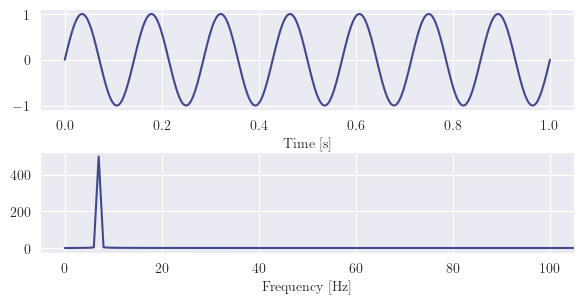

In [6]:
# Visualise the "continuous" 7 Hz sine wave
fig, axs = time_fourier_plot(t, x)
axs[1].set_xlim(-5, 105)

fname = Path(A1_ROOT, "output", "q6_sine7hz.png")
fig.savefig(fname, **SAVEFIG_CONFIG)

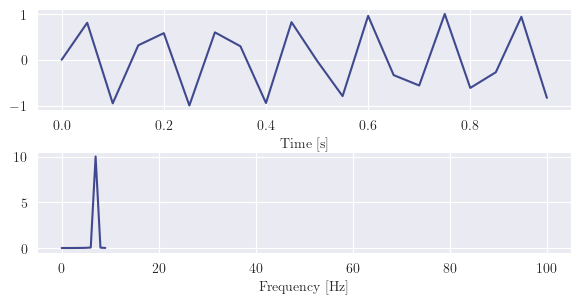

In [7]:
# Sample the "continuous" 7 Hz sine wave at 20 Hz (above Nyquist freq. of 14 Hz)
t_samp = t[::1000//20]
x_samp = x[::1000//20]

# Visualise the sampled signal (it looks quite terrible)
fig, axs = time_fourier_plot(t_samp, x_samp)
axs[1].set_xlim(-5, 105)

fname = Path(A1_ROOT, "output", "q6_sampled.png")
fig.savefig(fname, **SAVEFIG_CONFIG)

### Question 6: Sinc interpolation

In [17]:
# Define a function to perform sinc interpolation on an arbitrary signal
def sinc_interpolate(x: np.array, n: int, viz: bool = False) -> np.array:
    """
    Upsamples the given signal by the specified factor using sinc interpolation.
    """
    # Increases the sampling rate of x by inserting n-1 zeros between samples
    x_upsamp = np.concatenate([[p]+[0]*(n-1) for p in x])

    # Convolve with sinc in time domain by applying rect window in freq. domain
    H_upsamp = fft(x_upsamp)
    H_upsamp[10:-10] = 0
    x_interp = ifft(H_upsamp).real

    return x_interp

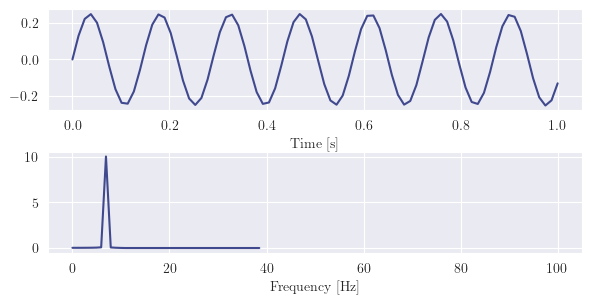

In [19]:
# Perform sinc interpolation on the sampled signal
t_interp = np.linspace(0, 1, 80)
x_sinc_interp = sinc_interpolate(x_samp, 4, viz=True)

# Visualise the sinc interpolated signal (it looks much better)
fig, axs = time_fourier_plot(t_interp, x_sinc_interp)
axs[1].set_xlim(-5, 105)

fname = Path(A1_ROOT, "output", "q6_upsampled.png")
fig.savefig(fname, **SAVEFIG_CONFIG)

### Question 7: Zero-padding in the Fourier domain

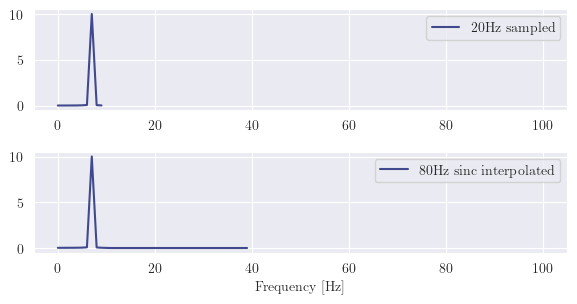

In [24]:
# Compare the sampled and sinc interpolated signals in the Fourier domain
fig, axs = plt.subplots(2, figsize=(6, 3))
fig.tight_layout()

# Sampled signal
f_samp = fftfreq(n=20, d=1/20)[:len(x_samp)//2]
H_samp = np.abs(fft(x_samp))[:len(x_samp)//2]

# Interpolated signal
N_interp = len(x_sinc_interp)
f_interp = fftfreq(n=80, d=1/80)[:N_interp//2]
H_sinc_interp = np.abs(fft(x_sinc_interp))[:N_interp//2]

sns.lineplot(x=f_samp, y=H_samp, ax=axs[0], label="20Hz sampled")
sns.lineplot(x=f_interp, y=H_sinc_interp, ax=axs[1], 
    label="80Hz sinc interpolated")

axs[0].set_xlim([-5, 105])
axs[1].set_xlim([-5, 105])

axs[1].set_xlabel("Frequency [Hz]")

fname = Path(A1_ROOT, "output", "q7_freqcompare.png")
fig.savefig(fname, **SAVEFIG_CONFIG)

In [26]:
# Define a function to perform interpolation on an arbitrary signal by
# Fourier domain zero-padding
def fourier_interpolate(x: np.array, n: int) -> np.array:
    """
    Upsamples the given signal by the specified factor by applying the Fourier
    transform, zero-padding, then inverse Fourier transforming.
    """
    H = fft(x); N = len(H)

    # Pad N*(n-1) zeros between positive and negative frequencies
    H_upsamp = np.concatenate([H[:N//2], np.zeros(len(x)*(n-1)), H[N//2:]])
    x_interp = ifft(H_upsamp).real

    return x_interp

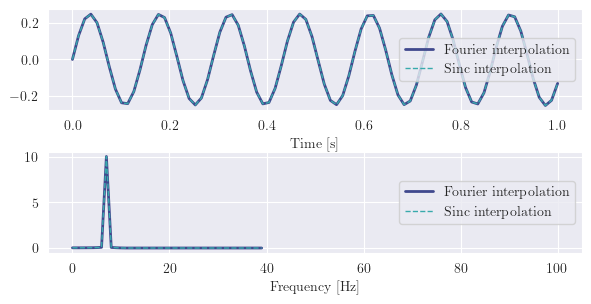

In [27]:
# Perform Fourier domain zero-padding to interpolate the sampled signal
x_ffts_interp = fourier_interpolate(x_samp, 4)
H_ffts_interp = np.abs(fft(x_ffts_interp))[:N_interp//2]

# Visualise the interpolated signal alongside the previous sinc interpolation
fig, axs = plt.subplots(2, figsize=(6, 3))
fig.tight_layout()

sns.lineplot(x=t_interp, y=x_ffts_interp, ax=axs[0], ls="-",  lw=2,
    label="Fourier interpolation")
sns.lineplot(x=t_interp, y=x_sinc_interp, ax=axs[0], ls="--", lw=1,
    label="Sinc interpolation")

sns.lineplot(x=f_interp, y=H_ffts_interp, ax=axs[1], ls="-",  lw=2,
    label="Fourier interpolation")
sns.lineplot(x=f_interp, y=H_sinc_interp, ax=axs[1], ls="--", lw=1,
    label="Sinc interpolation")

axs[0].set_xlabel("Time [s]")
axs[1].set_xlabel("Frequency [Hz]")

axs[0].legend(loc="center right")
axs[1].legend(loc="center right")

axs[1].set_xlim(-5, 105)

fname = Path(A1_ROOT, "output", "q7_upsampled.png")
fig.savefig(fname, **SAVEFIG_CONFIG)